### Install and import required dependencies

In [1]:
%%capture
!pip install kaggle
!pip install mtcnn
!pip install onnx

In [2]:
# Import necessary libraries
import glob
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from PIL import Image
import numpy as np
from collections import defaultdict
from mtcnn.mtcnn import MTCNN


### Data Loading and Preprocessing

First, you will need to connect to kaggle using its API to access the dataset. For more information about how to do so, please follow instructions in this  [link](https://www.kaggle.com/discussions/general/74235#:~:text=Using%20Secrets%20in%20Google%20Colab).

In [3]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download -d jessicali9530/lfw-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 98% 110M/112M [00:03<00:00, 38.4MB/s]
100% 112M/112M [00:03<00:00, 34.5MB/s]


In [5]:
%%capture
!mkdir lfw-dataset
!unzip lfw-dataset.zip -d lfw-dataset

Show image samples

In [6]:
data_path = 'lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/'

In [7]:
# List the directories (each directory is an individual)
subjects = os.listdir(data_path)
print(f"Total number of subjects: {len(subjects)}")


Total number of subjects: 5749


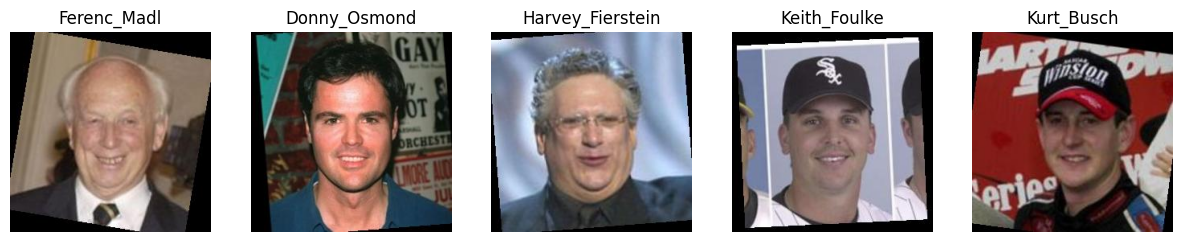

In [8]:
# Display some random images
def show_random_images(data_path, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax in axes:
        person = random.choice(subjects)
        person_path = os.path.join(data_path, person)
        image = random.choice(os.listdir(person_path))
        image_path = os.path.join(person_path, image)
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(person)
        ax.axis('off')
    plt.show()

show_random_images(data_path)

In [9]:
# Count images per subject
image_count = defaultdict(int)

for subject in subjects:
    subject_path = os.path.join(data_path, subject)
    num_images = len(os.listdir(subject_path))
    image_count[subject] = num_images

# Individual with maximum images
max_images_subject = max(image_count, key=image_count.get)
print(f"Individual with maximum images: {max_images_subject} ({image_count[max_images_subject]} images)")

# Subjects with only one image
one_image_subjects = [subject for subject, count in image_count.items() if count == 1]
print(f"Number of subjects with only one image: {len(one_image_subjects)}")

Individual with maximum images: George_W_Bush (530 images)
Number of subjects with only one image: 4069


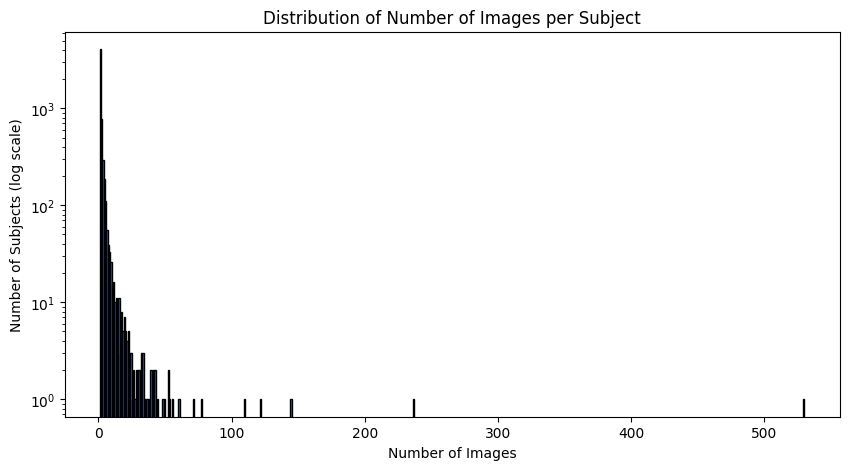

In [10]:
# Distribution of number of images per subject
image_counts = list(image_count.values())

plt.figure(figsize=(10, 5))
plt.hist(image_counts, bins=range(1, max(image_counts)+1), edgecolor='black',log=True)
plt.title('Distribution of Number of Images per Subject')
plt.xlabel('Number of Images')
plt.ylabel('Number of Subjects (log scale)')
plt.show()

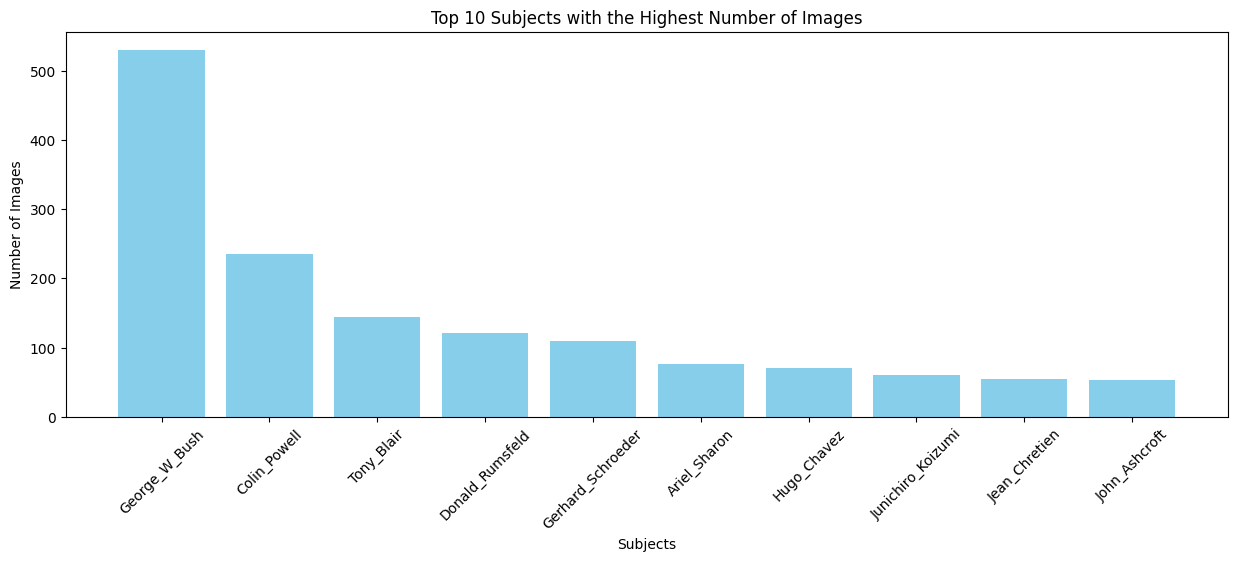

In [11]:
# Display subjects with the highest counts of images
sorted_counts = sorted(image_count.items(), key=lambda x: x[1], reverse=True)[:10]

# Bar plot for subjects with the highest counts of images
subjects_top = [item[0] for item in sorted_counts]
counts_top = [item[1] for item in sorted_counts]

plt.figure(figsize=(15, 5))
plt.bar(subjects_top, counts_top, color='skyblue')
plt.title('Top 10 Subjects with the Highest Number of Images')
plt.xlabel('Subjects')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


### Prepare the Dataset

In [12]:
# Define root directory for the dataset
root_dir = "lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

# Get all image paths
all_images = glob.glob(root_dir + "*/*.jpg")

# Shuffle and split images into training and testing sets
random.shuffle(all_images)
split_factor = 0.8
train_images = all_images[0:int(len(all_images) * split_factor)]
test_images = all_images[int(len(all_images) * split_factor):]

print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")


Number of training images: 10586
Number of testing images: 2647


### Create Image Pairs for Training and Testing

In [13]:
num_pairs_train = 5000
num_pairs_test = 1000

# Create pairs for training
train_pairs = []
anchors = []

# Positive pairs
for _ in tqdm(range(int(num_pairs_train / 2))):
    img1 = random.choice(train_images)
    while img1 in anchors:
        img1 = random.choice(train_images)
    anchors.append(img1)
    class_img1 = img1.split("/")[-2]
    same_class_images = glob.glob(root_dir + class_img1 + "/*")
    img2 = random.choice(same_class_images)
    img1 = img1.split(root_dir)[-1]
    img2 = img2.split(root_dir)[-1]
    train_pairs.append([img1, img2, 1])

# Negative pairs
for _ in tqdm(range(int(num_pairs_train / 2))):
    img1 = random.choice(train_images)
    while img1 in anchors:
        img1 = random.choice(train_images)
    anchors.append(img1)
    class_img1 = img1.split("/")[-2]
    while True:
        img2 = random.choice(train_images)
        class_img2 = img2.split("/")[-2]
        if class_img2 != class_img1:
            break
    img1 = img1.split(root_dir)[-1]
    img2 = img2.split(root_dir)[-1]
    train_pairs.append([img1, img2, 0])

# Create pairs for testing
test_pairs = []
anchors = []

# Positive pairs
for _ in tqdm(range(int(num_pairs_test / 2))):
    img1 = random.choice(test_images)
    while img1 in anchors:
        img1 = random.choice(test_images)
    anchors.append(img1)
    class_img1 = img1.split("/")[-2]
    same_class_images = glob.glob(root_dir + class_img1 + "/*")
    img2 = random.choice(same_class_images)
    img1 = img1.split(root_dir)[-1]
    img2 = img2.split(root_dir)[-1]
    test_pairs.append([img1, img2, 1])

# Negative pairs
for _ in tqdm(range(int(num_pairs_test / 2))):
    img1 = random.choice(test_images)
    while img1 in anchors:
        img1 = random.choice(test_images)
    anchors.append(img1)
    class_img1 = img1.split("/")[-2]
    while True:
        img2 = random.choice(test_images)
        class_img2 = img2.split("/")[-2]
        if class_img2 != class_img1:
            break
    img1 = img1.split(root_dir)[-1]
    img2 = img2.split(root_dir)[-1]
    test_pairs.append([img1, img2, 0])

# Ensure pairs are unique
train_pairs = random.sample(train_pairs, len(train_pairs))
test_pairs = random.sample(test_pairs, len(test_pairs))

# Save pairs to text files
os.makedirs("files/couples", exist_ok=True)

with open("files/couples/train.txt", "w") as train_writer:
    for pair in train_pairs:
        train_writer.write(f"{pair[0]} {pair[1]} {pair[2]}\n")

with open("files/couples/test.txt", "w") as test_writer:
    for pair in test_pairs:
        test_writer.write(f"{pair[0]} {pair[1]} {pair[2]}\n")


100%|██████████| 500/500 [00:00<00:00, 29499.96it/s]


In [14]:

def align_face(im):
    im = np.asarray(im)
    detector = MTCNN()
    results = detector.detect_faces(im)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = im[y1:y2, x1:x2]
    face_image = Image.fromarray(face)
    return face_image

class Face_Dataset(Dataset):

    def __init__(self, root_dir, file_root, train=False, test=False):
        self.train = train
        self.test = test
        self.root_dir = root_dir
        self.files = []
        self.labels = []

        dataset = set()
        if self.train:
            filename = file_root + 'couples/train.txt'
        else:
            filename = file_root + 'couples/test.txt'

        self.transform = self.load_transforms()
        with open(filename) as f:
            for line in f:
                line = line.split()
                self.files.append(line[:2])
                self.labels.append(int(line[2]))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        im_names = self.files[idx]
        im1 = Image.open(os.path.join(self.root_dir, im_names[0]))
        im2 = Image.open(os.path.join(self.root_dir, im_names[1]))
        label = np.array([abs(self.labels[idx])], dtype=np.float32)

        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)

        label = torch.from_numpy(label)
        return im1, im2, label

    def align_face(self, im):
        im = np.asarray(im)
        detector = MTCNN()
        results = detector.detect_faces(im)
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = im[y1:y2, x1:x2]
        face_image = Image.fromarray(face)
        return face_image

    def load_transforms(self):
        if self.train:
            tet = transforms.Compose([transforms.Resize((160, 160)),
                                       transforms.RandomAffine(15),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ColorJitter(
                                          brightness=0.3,
                                          contrast=0.3,
                                          saturation=0.3),
                                       transforms.ToTensor()])
        else:
            tet = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor()])
        return tet

# Initialize datasets
face_data_train = Face_Dataset(root_dir, 'files/', train=True)
face_data_test = Face_Dataset(root_dir, 'files/', test=True)


### Visualize Sample Pairs


Label: 0.0 (dissimilar)


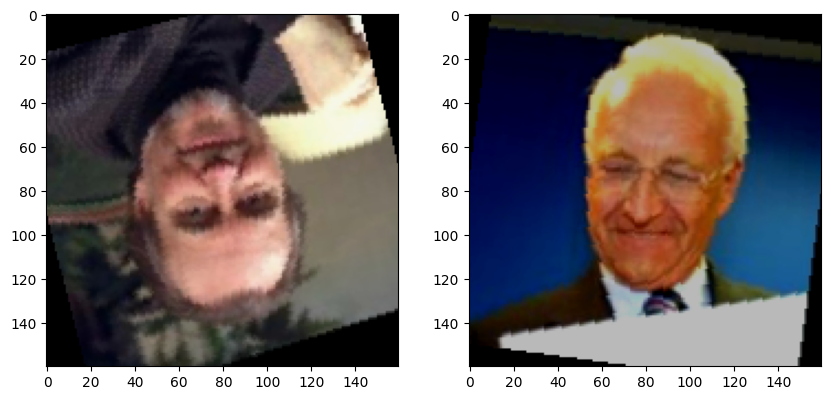

Label: 0.0 (dissimilar)


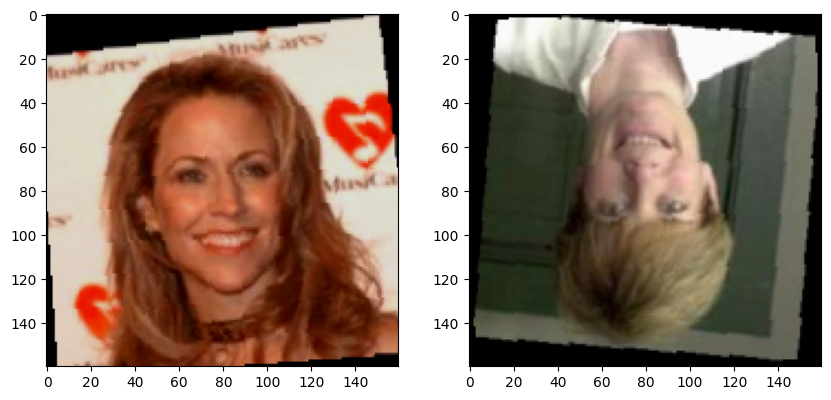

Label: 1.0 (similar)


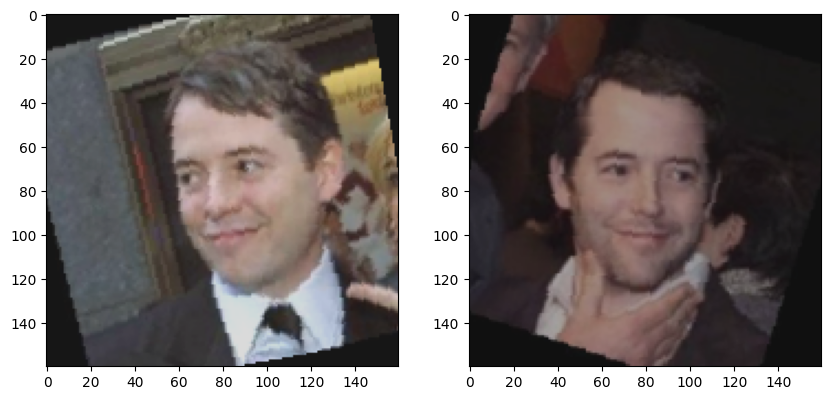

Label: 1.0 (similar)


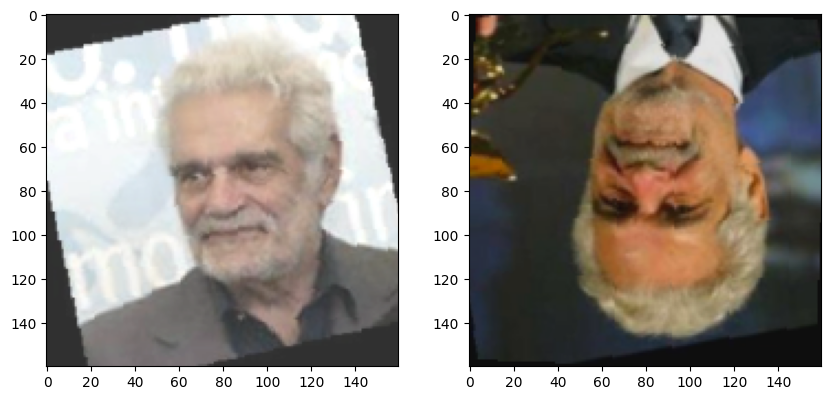

Label: 1.0 (similar)


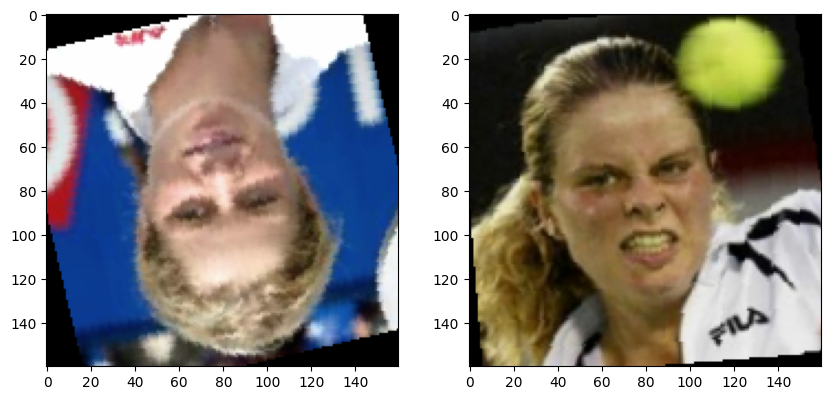

In [15]:
# Visualize some sample pairs from the training set
for i in range(5):
    index = random.randint(1, len(face_data_train))
    img1 = transforms.ToPILImage()(face_data_train[index][0])
    img2 = transforms.ToPILImage()(face_data_train[index][1])
    label = face_data_train[index][2].item()
    similar = 'similar' if label == 1.0 else 'dissimilar'

    print(f"Label: {label} ({similar})")
    fig = plt.figure(figsize=(10, 10))
    ax = []
    ax.append(fig.add_subplot(1, 2, 1))
    plt.imshow(img1)

    ax.append(fig.add_subplot(1, 2, 2))
    plt.imshow(img2)

    plt.show()



Label: 0.0 (dissimilar)


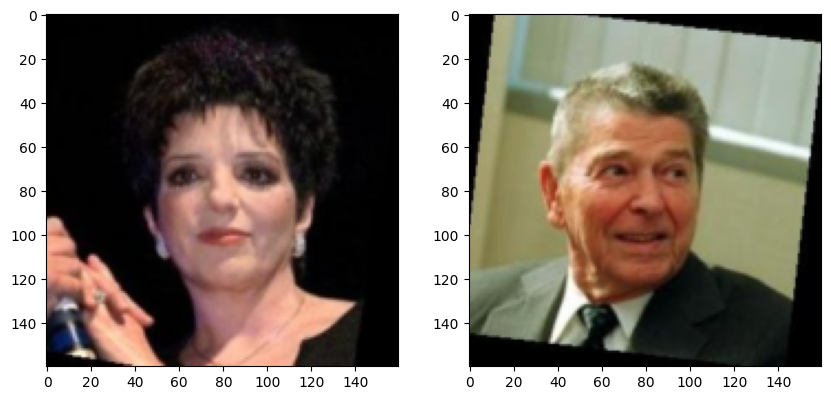

Label: 1.0 (similar)


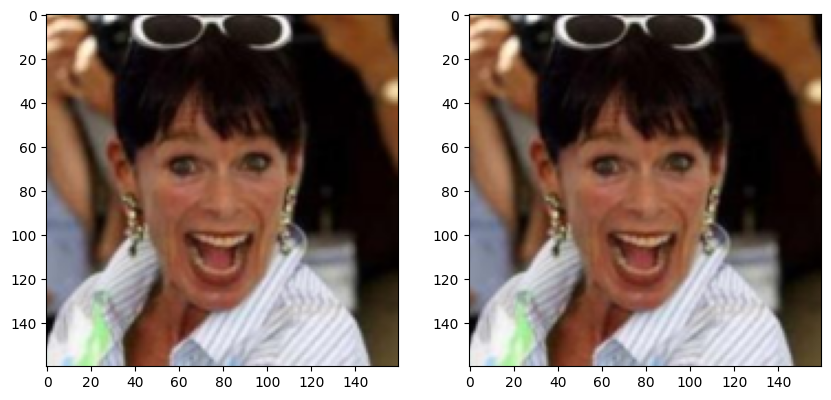

Label: 0.0 (dissimilar)


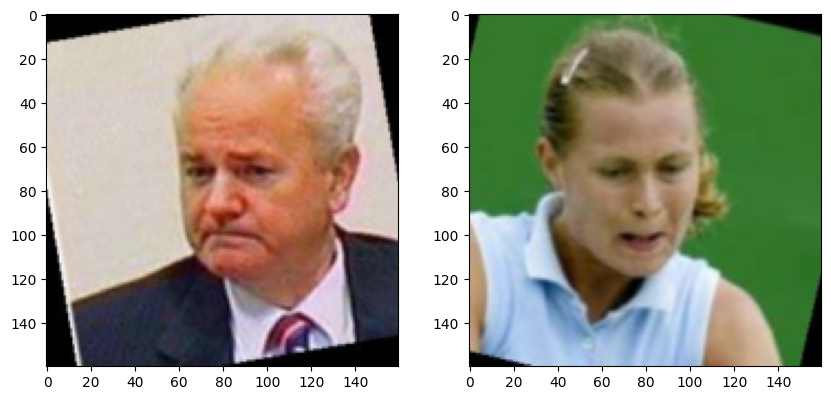

Label: 1.0 (similar)


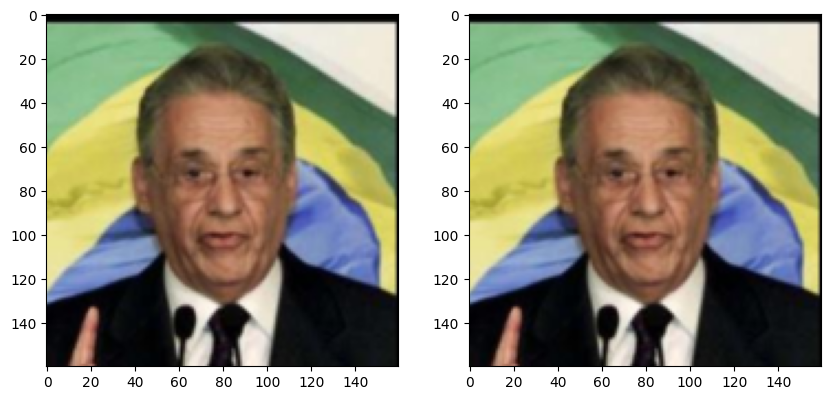

Label: 1.0 (similar)


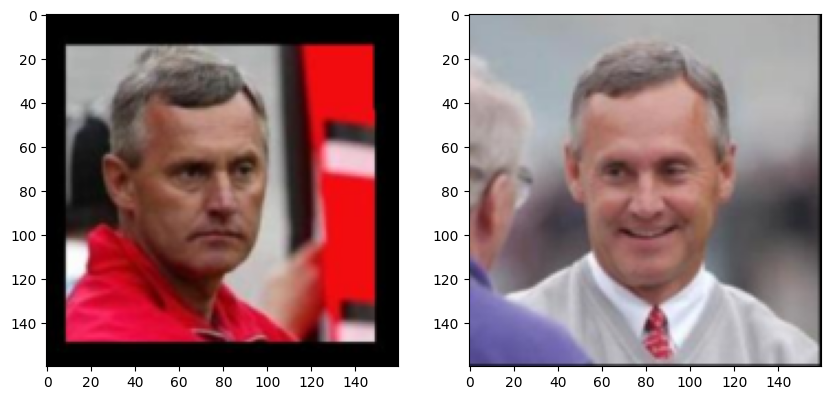

In [18]:

# Visualize some sample pairs from the testing set
for i in range(5):
    index = random.randint(1, len(face_data_test))
    img1 = transforms.ToPILImage()(face_data_test[index][0])
    img2 = transforms.ToPILImage()(face_data_test[index][1])
    label = face_data_test[index][2].item()
    similar = 'similar' if label == 1.0 else 'dissimilar'

    print(f"Label: {label} ({similar})")
    fig = plt.figure(figsize=(10, 10))
    ax = []
    ax.append(fig.add_subplot(1, 2, 1))
    plt.imshow(img1)

    ax.append(fig.add_subplot(1, 2, 2))
    plt.imshow(img2)

    plt.show()

### Define and Train the Siamese Network

In [16]:
# Define the base network architecture
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 20 * 20, 512)
        self.fc2 = nn.Linear(512, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define the Siamese network architecture
class SiameseNetwork(nn.Module):
    def __init__(self, base_network):
        super(SiameseNetwork, self).__init__()
        self.base_network = base_network

    def forward(self, img1, img2):
        feat1 = self.base_network(img1)
        feat2 = self.base_network(img2)
        return feat1, feat2


# Define contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [17]:
base_network = BaseNetwork().cuda()
siamese_network = SiameseNetwork(base_network).cuda()

# Set hyperparameters
batch_size = 32
lr = 1e-2
n_epochs = 20
log_interval = 50

# Initialize dataloaders
train_dataloader = DataLoader(face_data_train, shuffle=True, num_workers=8, batch_size=batch_size)
test_dataloader = DataLoader(face_data_test, shuffle=True, num_workers=8, batch_size=batch_size)

# Initialize loss function, optimizer, and scheduler
criterion = ContrastiveLoss()
optimizer = optim.SGD(siamese_network.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 4, gamma=0.1, last_epoch=-1)

# Training function
def train_epoch(train_dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0

    for batch_idx, data in enumerate(train_dataloader):
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels = data[2].cuda()

        optimizer.zero_grad()

        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

# Validation function
def validate_epoch(test_dataloader, model, criterion):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloader):
            img1 = data[0].cuda()
            img2 = data[1].cuda()
            labels = data[2].cuda()

            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, labels)
            val_loss += loss.item()

    val_loss /= (batch_idx + 1)
    return val_loss

# Save model function
def save_model(model, exp_name):
    experiment_name = f"experiments/best_{exp_name}.pth"
    torch.save(model.state_dict(), experiment_name)

# Create experiments directory
os.makedirs("experiments", exist_ok=True)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/20, Train Loss: 0.9537, Val Loss: 0.8368
Epoch 2/20, Train Loss: 0.8250, Val Loss: 0.6850
Epoch 3/20, Train Loss: 0.7982, Val Loss: 0.6635
Epoch 4/20, Train Loss: 0.7752, Val Loss: 0.6486
Epoch 5/20, Train Loss: 0.7362, Val Loss: 0.6589
Epoch 6/20, Train Loss: 0.7218, Val Loss: 0.6461
Epoch 7/20, Train Loss: 0.7234, Val Loss: 0.6581
Epoch 8/20, Train Loss: 0.7162, Val Loss: 0.6531
Epoch 9/20, Train Loss: 0.7100, Val Loss: 0.6621
Epoch 10/20, Train Loss: 0.7082, Val Loss: 0.6516
Epoch 11/20, Train Loss: 0.7057, Val Loss: 0.6602
Epoch 12/20, Train Loss: 0.7045, Val Loss: 0.6414
Epoch 13/20, Train Loss: 0.7161, Val Loss: 0.6515
Epoch 14/20, Train Loss: 0.7151, Val Loss: 0.6579
Epoch 15/20, Train Loss: 0.7131, Val Loss: 0.6495
Epoch 16/20, Train Loss: 0.7123, Val Loss: 0.6499
Epoch 17/20, Train Loss: 0.7066, Val Loss: 0.6701
Epoch 18/20, Train Loss: 0.7176, Val Loss: 0.6505
Epoch 19/20, Train Loss: 0.7089, Val Loss: 0.6592
Epoch 20/20, Train Loss: 0.7132, Val Loss: 0.6581


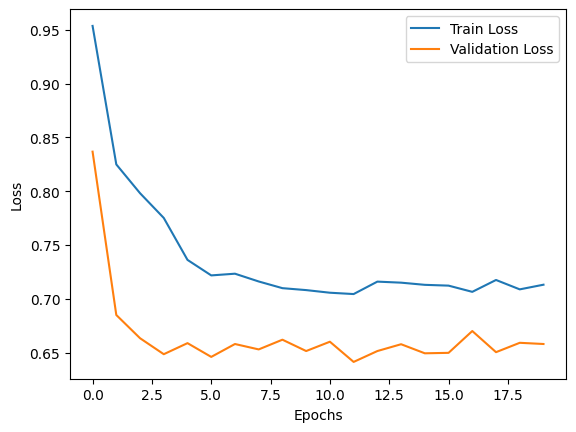

In [18]:

# Training loop
train_losses = []
val_losses = []
best_loss = np.inf
exp_name = "siamese_network"

for epoch in range(n_epochs):
    train_loss = train_epoch(train_dataloader, siamese_network, criterion, optimizer)
    val_loss = validate_epoch(test_dataloader, siamese_network, criterion)
    scheduler.step()

    if val_loss < best_loss:
        best_loss = val_loss
        save_model(siamese_network, exp_name)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Load the Trained Model and Evaluate

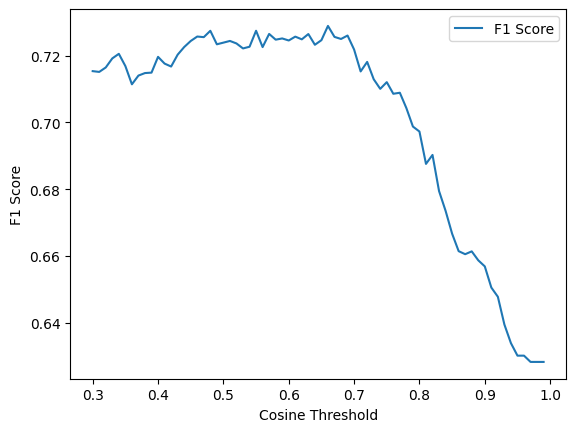

At threshold 0.6600, we get a maximum F1 score of 0.7289


In [19]:
# Load the trained model
def load_model(model, exp_name):
    experiment_name = f"experiments/best_{exp_name}.pth"
    model.load_state_dict(torch.load(experiment_name))
    return model

# Initialize and load the model
base_network = BaseNetwork()
siamese_network = SiameseNetwork(base_network)
siamese_network = load_model(siamese_network, exp_name)
siamese_network = siamese_network.cuda()
siamese_network.eval()

# Evaluate the model on the test set
labels = []
cosine_similarity = []
euclidean_distances = []

for data in test_dataloader:
    siamese_network.eval()
    with torch.no_grad():
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels += list(data[2].numpy().flatten().astype(int))

        embedding1, embedding2 = siamese_network(img1, img2)

        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cosine_similarity += list(cos(embedding1, embedding2).cpu().numpy())

        euclidean_distance = F.pairwise_distance(embedding1, embedding2, keepdim=True)
        euclidean_distances += list(euclidean_distance.cpu().numpy())

# Calculate and plot F1 score and accuracy at different thresholds
thresholds = list(np.arange(0.3, 1.0, 0.01))
f1_scores = [f1_score(labels, np.array(cosine_similarity) > t) for t in thresholds]

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Cosine Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)
print(f"At threshold {thresholds[max_f1_index]:.4f}, we get a maximum F1 score of {max_f1:.4f}")


### Run Inferences

In [33]:
# Open the test pairs file and read all lines
with open("files/couples/test.txt") as f:
    lines = f.readlines()

    # Find a similar pair (label == 1)
    while True:
        line = random.choice(lines)
        img1 = line.split(" ")[0]
        img2 = line.split(" ")[1]
        label = line.split(" ")[2][0]

        if label == "1":
            similar_pair = [img1, img2]
            break

    # Find a dissimilar pair (label == 0)
    while True:
        line = random.choice(lines)
        img1 = line.split(" ")[0]
        img2 = line.split(" ")[1]
        label = line.split(" ")[2][0]

        if label == "0":
            dissimilar_pair = [img1, img2]
            break

# Print the selected pairs
print(similar_pair)
print(dissimilar_pair)

['Martha_Bowen/Martha_Bowen_0001.jpg', 'Martha_Bowen/Martha_Bowen_0002.jpg']
['Nicole_Kidman/Nicole_Kidman_0001.jpg', 'Tony_Stewart/Tony_Stewart_0001.jpg']


Cosine_Similarity : 0.7972036600112915
Detected : similar


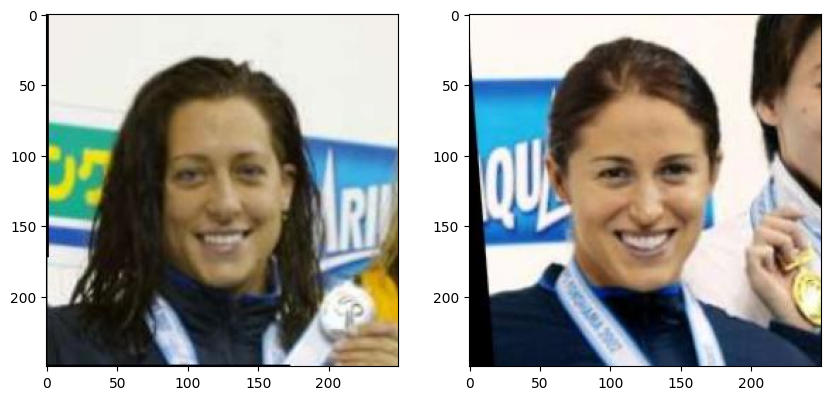

In [34]:

# Define the root directory for the images
root_dir = "lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

# Paths for the similar pair images
img1_path = similar_pair[0]
img2_path = similar_pair[1]

# Open the images using Pillow
img1 = Image.open(os.path.join(root_dir, img1_path))
img2 = Image.open(os.path.join(root_dir, img2_path))

# Resize the images to the required size
new_size = (160, 160)
resized_img1 = img1.resize(new_size, Image.LANCZOS)
resized_img2 = img2.resize(new_size, Image.LANCZOS)

# Transform the images to tensors and move to GPU
T_img1 = transforms.ToTensor()(resized_img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(resized_img2).unsqueeze(0).cuda()

# Get the embeddings for both images using the Siamese network
embedding1, embedding2 = siamese_network(T_img1, T_img2)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
# Calculate cosine similarity between the embeddings
cosine_similarity = cos(embedding1, embedding2).item()

# Determine if the images are similar or dissimilar based on a threshold
similarity = "similar" if cosine_similarity > 0.66 else "dissimilar"

# Print the results
print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))

# Plot the images with their similarity result
fig = plt.figure(figsize=(10, 10))
ax = []
ax.append(fig.add_subplot(1, 2, 1))
plt.imshow(img1)

ax.append(fig.add_subplot(1, 2, 2))
plt.imshow(img2)

plt.show()



Cosine_Similarity : 0.44710737466812134
Detected : dissimilar


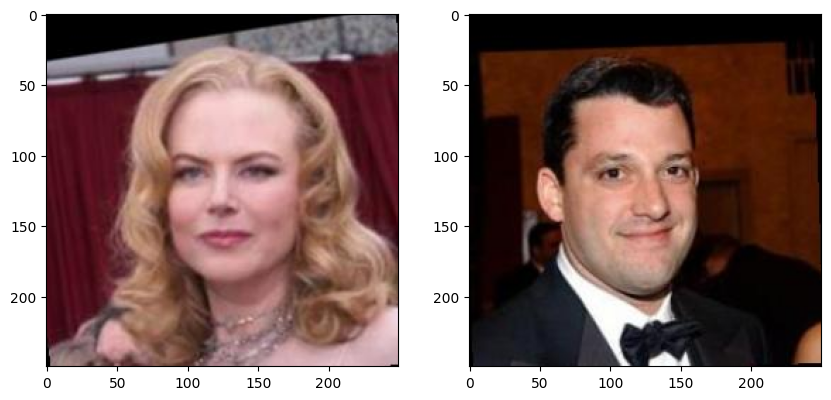

In [35]:
#Repeat the process for the dissimilar pair

# Paths for the dissimilar pair images
img1_path = dissimilar_pair[0]
img2_path = dissimilar_pair[1]

# Open the images using Pillow
img1 = Image.open(os.path.join(root_dir, img1_path))
img2 = Image.open(os.path.join(root_dir, img2_path))

# Resize the images to the required size
new_size = (160, 160)
resized_img1 = img1.resize(new_size, Image.LANCZOS)
resized_img2 = img2.resize(new_size, Image.LANCZOS)

# Transform the images to tensors and move to GPU
T_img1 = transforms.ToTensor()(resized_img1).unsqueeze(0).cuda()
T_img2 = transforms.ToTensor()(resized_img2).unsqueeze(0).cuda()

# Get the embeddings for both images using the Siamese network
embedding1, embedding2 = siamese_network(T_img1, T_img2)

# Calculate cosine similarity between the embeddings
cosine_similarity = cos(embedding1, embedding2).item()

# Determine if the images are similar or dissimilar based on a threshold
similarity = "similar" if cosine_similarity > 0.66 else "dissimilar"

# Print the results
print("Cosine_Similarity : {}".format(cosine_similarity))
print("Detected : {}".format(similarity))

# Plot the images with their similarity result
fig = plt.figure(figsize=(10, 10))
ax = []
ax.append(fig.add_subplot(1, 2, 1))
plt.imshow(img1)

ax.append(fig.add_subplot(1, 2, 2))
plt.imshow(img2)

plt.show()

## Conver to ONNX

In [37]:
# Create dummy input data
dummy_input1 = torch.randn(1, 3, 160, 160).cuda()
dummy_input2 = torch.randn(1, 3, 160, 160).cuda()

# Export the model to ONNX
onnx_model_path = "django-app/onnxmodel/siamese_network.onnx"
torch.onnx.export(
    siamese_network,                    # Model to be exported
    (dummy_input1, dummy_input2),       # Model inputs
    onnx_model_path,                    # Where to save the ONNX file
    export_params=True,                 # Store the trained parameter weights inside the model file
    opset_version=11,                   # ONNX version to export the model to
    do_constant_folding=True,           # Whether to execute constant folding for optimization
    input_names=['input1', 'input2'],   # Input names for the model
    output_names=['output1', 'output2'],# Output names for the model
    dynamic_axes={
        'input1': {0: 'batch_size'},    # Variable-length axes
        'input2': {0: 'batch_size'},
        'output1': {0: 'batch_size'},
        'output2': {0: 'batch_size'}
    }
)

print(f"Model has been converted to ONNX and saved at {onnx_model_path}")

Model has been converted to ONNX and saved at siamese_network.onnx
